# Getting Started with Unstructured API and Snowflake


[Unstructured](https://unstructured.io) is a unique ETL+ solution for preprocessing unstructured data for GenAI applications. With it, you can:

* Connect to enterprise data systems, such as cloud storage (Azure Blob storage, Amazon S3, etc.), business collaboration platforms(Confluence, Dropbox, etc.), business applications (e.g. Salesforce, Jira, Zendesk), cloud-based document storage(Google Drive, OneDrive, etc.),
* Continuously ingest the data from your data sources
* Preprocess the data in a standardized manner accross all the sources, enrich it, chunk, and generate embeddings, and
* Upload structured results into a **Snowflake Table**.

You can create and manage Unstructured connectors and data processing workflows via UI, headless API, or MCP.

In this comprehensive notebook you'll learn how to create your data processing workflows with Unstructured API with its Python SDK to preprocess all of your unstructured data into your Snowflake Table. We will use Azure Blob Storage as a source of data in this example (you can switch to any other [source](https://docs.unstructured.io/api-reference/workflow/sources/overview)), and this is what the data processing pipeline will look like:

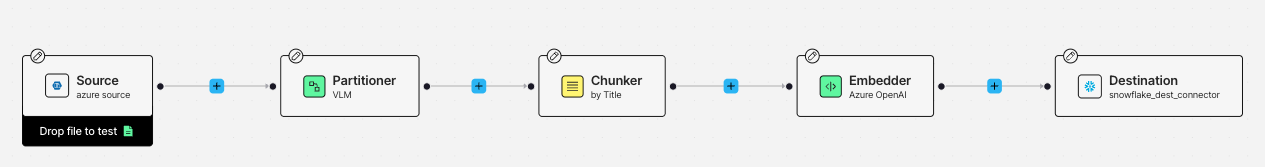


## Prerequisites

**Unstructured**

An Unstructured API key. [Learn how to get one](https://docs.unstructured.io/platform-api/api/overview).

**Azure**

You'll need an **Azure account** with access to **Azure Blob Storage**, along with your **storage account name** and a **shared access signature (SAS)** token for authentication. Make sure you've created a **container** within your storage account and that it has the appropriate access permissions. Upload a few files to your blob container so there's something to play with! 😉 Take a look at [this list](https://docs.unstructured.io/api-reference/supported-file-types) of supported file types and [this video](https://www.youtube.com/watch?time_continue=211&v=Vl3KCphlh9Y&embeds_referring_euri=https%3A%2F%2Fdocs.unstructured.io%2F&source_ve_path=MjM4NTE) on how you can set yours up.

**Snowflake**

To send processed data from Unstructured to Snowflake, you'll need:

* A Snowflake account and account identifier  
* A user login name and password  
* A role with access to the target database, schema, and warehouse  
* The deployment hostname and port number  
* A warehouse  
* A database  
* A schema  

You will have to create a table, so the role must have the following permissions:

* `USAGE` on the warehouse, database, and schema  
* `CREATE TABLE` on the schema  
* `INSERT`, `SELECT` on the table (for writing/reading data)

You can retrieve connection details from **Snowsight**.

The detailed information on everything you need to know to set up your Snowflake environment to work with Unstructured, including all necessary permissions, is listed in this [documentation page](https://docs.unstructured.io/ui/destinations/snowflake). We also included videos to help you get started!




## Step 1: Install the Unstructured API Python SDK

All functionality available in the the UI of the [Unstructured](https://unstructured.io/) product is also available programmatically via Unstructured API. You can interact with Unstructured API either by sending direct requests via curl or postman, or using Unstructured API [Python SDK](https://docs.unstructured.io/api-reference/workflow/overview#unstructured-python-sdk). Here, we'll be using the latter.


> **Note:**
The Unstructured API has two endpoints:
* The Unstructured Partition Endpoint: intended for rapid prototyping of Unstructured's various partitioning strategies. It works only with processing of local files, one file at a time.
* The Unstructured Workflow Endpoint: enables a full range of partitioning, chunking, embedding, and enrichment options for your data. It is designed to batch-process data from any data source to any destination. This is what we're using in this notebook.


Run the following cell to install the Unstructured API Python SDK.

In [ ]:
!pip install -U "unstructured-client"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 12.2 MB/s eta 0:00:00


## Step 2: Set environment variables

Replace the placeholders with the values for your API keys, secrets, etc:

In [ ]:
import os
from google.colab import userdata

# Unstructured
os.environ['UNSTRUCTURED_API_KEY'] = userdata.get('UNSTRUCTURED_API_KEY')

# Azure Blob Storage
os.environ['AZURE_REMOTE_URL'] = userdata.get('AZURE_REMOTE_URL')
os.environ['AZURE_ACCOUNT_NAME'] = userdata.get('AZURE_ACCOUNT_NAME')
os.environ['AZURE_SAS_TOKEN'] = userdata.get('AZURE_SAS_TOKEN')

# Snowflake
os.environ['SNOWFLAKE_ACCOUNT_IDENTIFIER'] = userdata.get('SNOWFLAKE_ACCOUNT_IDENTIFIER')
os.environ['SNOWFLAKE_LOGINNAME'] = userdata.get('SNOWFLAKE_LOGINNAME')
os.environ['SNOWFLAKE_ACCOUNT_PASSWORD'] = userdata.get('SNOWFLAKE_ACCOUNT_PASSWORD')

os.environ['SNOWFLAKE_DEPLOYMENT_HOSTNAME'] = userdata.get('SNOWFLAKE_DEPLOYMENT_HOSTNAME')
os.environ['SNOWFLAKE_DEPLOYMENT_PORTNUMBER'] = userdata.get('SNOWFLAKE_DEPLOYMENT_PORTNUMBER')

os.environ['DATABASE'] = userdata.get('DATABASE')
os.environ['SCHEMA'] = userdata.get('SCHEMA')
os.environ['TABLE'] = userdata.get('TABLE')

os.environ['ROLE'] = userdata.get('ROLE')

In [ ]:
# instantiate Unstructured Client
from unstructured_client import UnstructuredClient

unstructured_client = UnstructuredClient(api_key_auth=os.environ["UNSTRUCTURED_API_KEY"])

# helper function
def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

## Step 3: Create the source connector

Run the following cell to create the  [Azure Blob Storage source connector](https://docs.unstructured.io/api-reference/workflow/sources/azure-blob-storage).
When creating a source connector, you need to give it a unique name, specify its type (e.g. Azure, or Google Drive), and provide the configuration which typically contains the location of the source you're connecting to (e.g. Azure Remote URL) and authentication details.

In [ ]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import (
    CreateSourceConnector,
    SourceConnectorType,
    AzureSourceConnectorConfigInput
)


response = unstructured_client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name="azure_souce_connector",
            type=SourceConnectorType.AZURE,
            config=AzureSourceConnectorConfigInput(
                remote_url=os.environ['AZURE_REMOTE_URL'],
                recursive=True,

                account_name=os.environ['AZURE_ACCOUNT_NAME'],
                sas_token=os.environ['AZURE_SAS_TOKEN']

            )
        )
    )
)

source_connector_id = response.source_connector_information.id

## Step 4: Create the destination connector

Since your Snowflake environment variables have been configured configured (as outlined earlier), you can now create the destination connector.

This step defines the Snowflake destination by specifying a name, connector type, and required connection/config parameters (e.g., host, port, database, schema, role, credentials).






In [ ]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import (
    CreateDestinationConnector,
    DestinationConnectorType,
    SnowflakeDestinationConnectorConfigInput
)

response = unstructured_client.destinations.create_destination(
        request=CreateDestinationRequest(
            create_destination_connector=CreateDestinationConnector(
                name="snowflake_dest_connector",
                type=DestinationConnectorType.SNOWFLAKE,
                config=SnowflakeDestinationConnectorConfigInput(
                    account=os.environ['SNOWFLAKE_ACCOUNT_IDENTIFIER'],
                    user=os.environ['SNOWFLAKE_LOGINNAME'],
                    host=os.environ['SNOWFLAKE_DEPLOYMENT_HOSTNAME'],
                    port=int(os.environ['SNOWFLAKE_DEPLOYMENT_PORTNUMBER']),
                    database=os.environ['DATABASE'],
                    schema=os.environ['SCHEMA'],
                    role=os.environ['ROLE'],
                    password=os.environ['SNOWFLAKE_ACCOUNT_PASSWORD'],
                    record_id_key="RECORD_ID",
                    table_name=os.environ['TABLE'],
                    batch_size=20
                )
            )
        )
    )

destination_connector_id = response.destination_connector_information.id

## Step 5: Create the data processing workflow

A data processing workflow in Unstructured is a DAG (Directed acyclic graph) that ties together individual data processing steps.

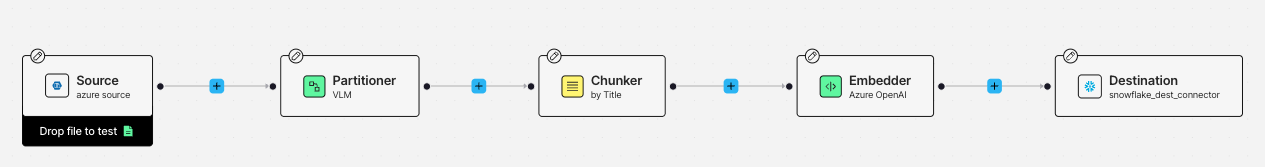

You can define each individual data processing step as a `WorkflowNode` and configure its parameters. The type of `WorkflowNode` determins what task it performs, while the settings specify how exactly it's executed. Let's take a closer look at the available Workflow Node types.

### `PARTITION`

This node is **required** in every workflow, and it has to be the first node in the DAG. Its task is to convert unstructured data into structured JSON format. Whether a document ingested from a source is a markdown file, email, or a PDF file, the resulting JSON file will have a standardized schema containing all of the document content and metadata. You can learn about the output JSON schema [here](https://docs.unstructured.io/api-reference/partition/document-elements).

At the time of writing, Unstructured offers 4 partitioning strategies:
* **Auto**, `subtype="vlm"`: A dynamic meta-strategy that selects the optimal partitioning approach—either `VLM`, `High Res`, or `Fast`—based on a document's unique characteristics, such as file type and page content. This strategy intelligently applies the most suitable method to minimize processing costs while maximizing accuracy.
* **VLM**, `subtype="vlm"`: A partitioning strategy that uses state-of-the-art VLMs (Vision-Language Models) to extract content from complex documents where traditional OCR struggles. It's ideal for challenging cases like noisy scans, handwriting, and complex nested forms.
* **High Res**, `subtype="unstructured_api"`: This approach combines advanced OCR with document understanding capabilities, making it effective for image-based documents like scanned files. Can handle documents with images and simple tables.
* **Fast**, `subtype="unstructured_api"`: A rapid strategy optimized for quick text extraction from documents such as markdown or office suite files. It's a cost-effective solution for documents with easily extractable text and no images.


### `PROMPTER`
Nodes of this type enrich your documents in one way or another. They can be used to generate image and/or table description, or extract named entities from the text to add to the metadata.
* **Image summarizer**: Enrichment that generates descriptions of images. Use one of the following subtypes: `openai_image_description`, `anthropic_image_description`, `bedrock_image_description`, `vertexai_image_description`.
* **Table summarizer**: Enrichment that generates descriptions of tables. Use one of the following subtypes: `openai_table_description`, `anthropic_table_description`, `bedrock_table_description`, `vertexai_table_description`.
* **Named entity recognizer**: Enrichment that generates extracts named entities from text and adds them as metadata. Can be used to build GraphRAG. Subtype: `openai_ner`.
* **Table to HTML**: Enrichment that converts adds the HTML version of a table to metadata. Subtype: `openai_table2html`.

In this example we won't be adding any enrichments.

### `CHUNK`

The chunking workflow node rearranges the document elements into manageable “chunks” to stay within the limits of an embedding model and to improve retrieval precision. You can learn more about chunking [here](https://docs.unstructured.io/ui/chunking).

### `EMBED`

After the data is partitioned, enriched and chunked, the embedding node can create vector representations of text, also called *embeddings*, that are used for similarity search in downstream applications. Learn mode about embeddings [here](https://docs.unstructured.io/ui/embedding)

Once you define your workflow nodes, you can create a workflow.
Run the following cell to create the workflow.

In [ ]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)

parition_node = WorkflowNode(
    name="Partitioner",
    subtype="vlm",
    type="partition",
    settings={
        "provider": "anthropic",
        "model": "claude-sonnet-4-5-20250929",
        }
    )

chunk_node = WorkflowNode(
    name='Chunker',
    subtype='chunk_by_title',
    type="chunk",
    settings={
        'new_after_n_chars': 1500,
        'max_characters': 2048,
        'overlap': 0
        }
    )

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type="embed",
    settings={
        'model_name': 'text-embedding-3-small'
        }
    )


response = unstructured_client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": "Azure-to-snowflake-table-custom-workflow_1373",
            "source_id": source_connector_id,
            "destination_id": destination_connector_id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                parition_node,
                chunk_node,
                embedder_node
            ],
            "schedule": Schedule("monthly")
        }
    }
)

pretty_print_model(response.workflow_information)
workflow_id = response.workflow_information.id

## Step 6: Run the workflow

Run the following cell to start running the workflow.

In [ ]:
res = unstructured_client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-04-22T13:09:20.477480Z",
    "id": "76f879a1-0951-4683-81d6-5bcd4d59715e",
    "status": "SCHEDULED",
    "workflow_id": "8eb5980b-16c0-48d2-b579-fe4162eec1e7",
    "workflow_name": "Azure-to-snowflake-table-custom-workflow_1373"
}


## Step 7: Get the workflow run's job ID

Run the following cell to get the workflow run's job ID, which is needed to poll for job completion later. If successful, Unstructured prints the job's ID.

In [ ]:
response = unstructured_client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: 76f879a1-0951-4683-81d6-5bcd4d59715e


## Step 8: Poll for job completion

Run the following cell to confirm the job has finished running. If successful, Unstructured prints `"status": "COMPLETED"` within the information about the job.

In [ ]:
import time

def poll_job_status(job_id, wait_time=30):
    while True:
        response = unstructured_client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-04-22T13:09:20.477480",
    "id": "76f879a1-0951-4683-81d6-5bcd4d59715e",
    "status": "COMPLETED",
    "workflow_id": "8eb5980b-16c0-48d2-b579-fe4162eec1e7",
    "workflow_name": "Azure-to-snowflake-table-custom-workflow_1373",
    "runtime": "PT0S"
}


## Step 9: View the processed data

Once the job is completed, your data is processed, and you can find it in your table under the schema you've specified.

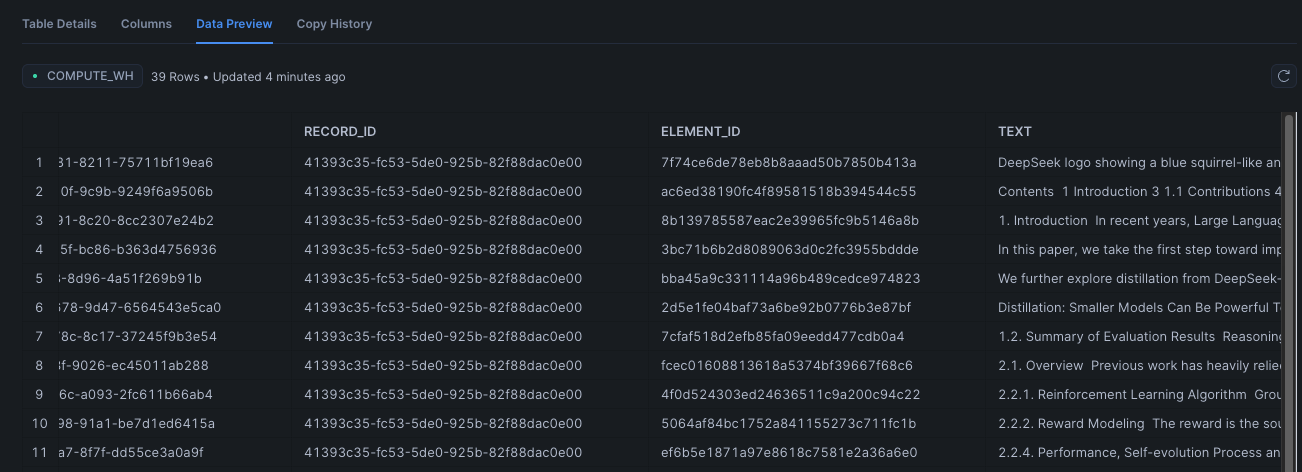